# Cleaning the dataset

## Table of contents

- [Table of contents](#table-of-contents)
- [Libraries](#libraries)
- [Global variables](#global-variables)
- [Load dataset](#load-dataset)
- [Clean by length](#remove-rows-with-a-very-short-or-very-long-content)

## Libraries

In [15]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import pandas as pd, torch, os, logging
from transformers import AutoTokenizer, AutoModelForCausalLM
import re

## Global variables

In [16]:
ROOT            = Path("../..") / "data"
PATH_ANONYM     = ROOT / "anonymous_forum.csv"
PATH_OUT = ROOT / "anonymous_forum_filtered.csv"

In [25]:
min_length = 5
max_length = 25

## Load dataset

In [19]:
df = pd.read_csv(PATH_ANONYM, sep=",", encoding="utf-8")

In [20]:
print(f"Number of rows before cleaning: {df.shape[0]}")
print(f"Columns: {df.columns.tolist()}")
df.head(3)

Number of rows before cleaning: 1886343
Columns: ['msg_id', 'user', 'content', 'topic', 'deleted', 'banned', 'hour']


,msg_id,user,content,topic,deleted,banned,hour
0,anon_msg_55908da50f0b,anon_user_a5f371a2c3,"La bière ""Urine de Go*"" vient d'arriver.",anon_topic_a181712c,0,0,18
1,anon_msg_ea38ee1dafc1,anon_user_4264024ed5,Ils ont pris le petit jeune de l'équipe payé a...,anon_topic_3e4caf2b,1,0,12
2,anon_msg_e340547f803a,anon_user_747ee094dd,Encore bonne chance kheyou,anon_topic_a32635ae,0,0,13


## Remove rows with a very short or very long content

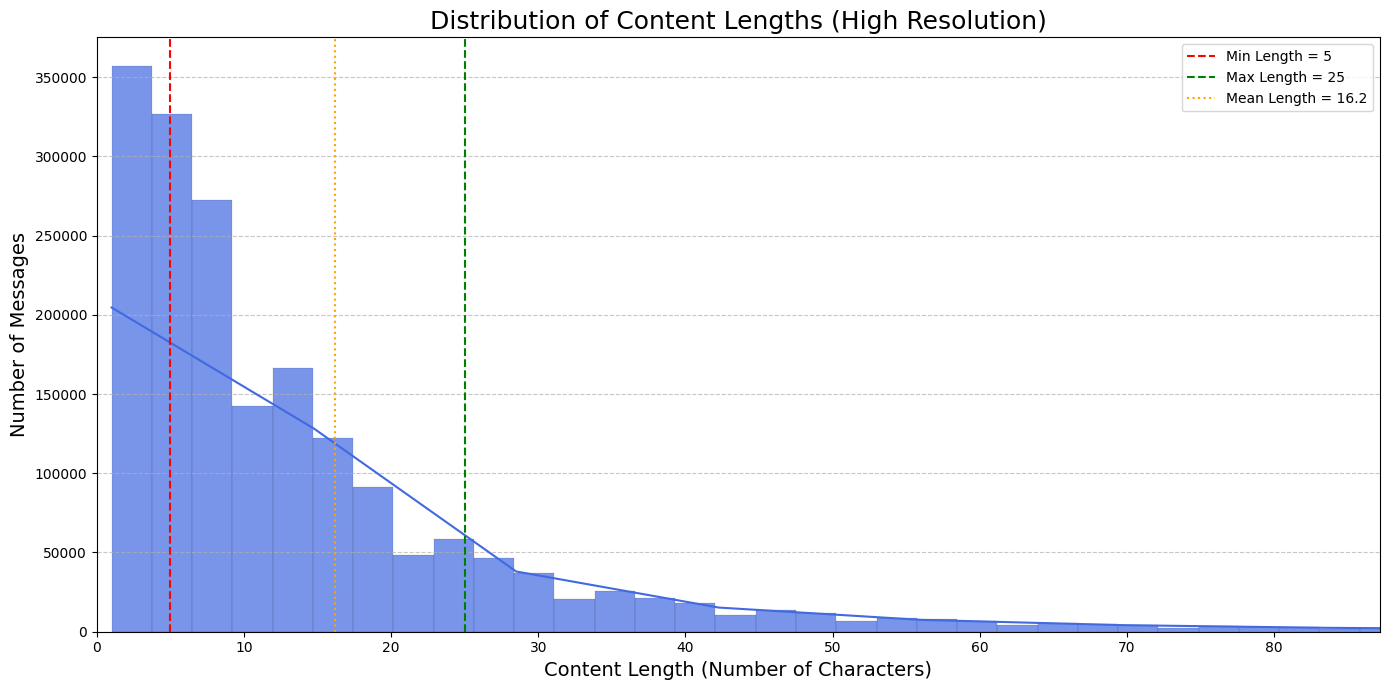

In [27]:
# Compute content length
df["content_length"] = df["content"].apply(lambda x: len(str(x).split()))

# Define max x-axis based on 99th percentile
xmax = df["content_length"].quantile(0.99)

# Plot
plt.figure(figsize=(14, 7))
sns.histplot(
    df["content_length"], 
    bins=1000,
    kde=True, 
    color="royalblue", 
    edgecolor="black", 
    alpha=0.7
)

# Threshold lines
plt.axvline(min_length, color="red", linestyle="--", label=f"Min Length = {min_length}")
plt.axvline(max_length, color="green", linestyle="--", label=f"Max Length = {max_length}")
mean_length = df["content_length"].mean()
plt.axvline(mean_length, color="orange", linestyle=":", label=f"Mean Length = {mean_length:.1f}")

# Axes settings
plt.xlim(0, 0.8 * xmax)
plt.ylim(0, None)  # Auto y scaling
plt.title("Distribution of Content Lengths (High Resolution)", fontsize=18)
plt.xlabel("Content Length (Number of Characters)", fontsize=14)
plt.ylabel("Number of Messages", fontsize=14)
plt.legend()
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [28]:
# Filter dataset
rows_before = df.shape[0]
df = df[(df["content_length"] >= min_length) & (df["content_length"] <= max_length)].reset_index(drop=True)
rows_after = df.shape[0]

print(f"Removed {rows_before - rows_after} rows with too short or too long content.")
print(f"Remaining rows after cleaning: {rows_after}")

# Drop helper column
df = df.drop(columns=["content_length"])

df.to_csv(PATH_OUT, sep=",", encoding="utf-8", index=False)

Removed 767543 rows with too short or too long content.
Remaining rows after cleaning: 1118800


## Mask the URLs

In [29]:
df = pd.read_csv(PATH_OUT, sep=",", encoding="utf-8")

In [30]:
patterns_to_remove = [
    r"https?://\S+",        # URLs
    r"www\.\S+",            # URLs starting with www
    r"\b\S+@\S+\.\S+\b",    # Emails
    r"\b\d{1,4}[-.\s]?\d{1,4}[-.\s]?\d{3,4}\b",  # Phone numbers (rough)
    r"@\w+",                # @usernames
    r"u/\w+",               # Reddit-style usernames
    r"\b\d{1,3}(\.\d{1,3}){3}\b", # IP addresses
]
combined_pattern = re.compile("|".join(patterns_to_remove), flags=re.IGNORECASE)

In [31]:
df["non_anonymized_flag"] = df["content"].apply(lambda x: bool(combined_pattern.search(x)))

In [32]:
non_anon_rows = df["non_anonymized_flag"].sum()
print(f"Found {non_anon_rows} rows with non-anonymized content.")

Found 31789 rows with non-anonymized content.


In [33]:
df = df[~df["non_anonymized_flag"]].reset_index(drop=True)

In [34]:
df = df.drop(columns=["non_anonymized_flag"])

In [35]:
df.to_csv(PATH_OUT, sep=",", encoding="utf-8", index=False)

print(f"Final cleaned dataset saved to {PATH_OUT}. Remaining rows: {df.shape[0]}")

Final cleaned dataset saved to ../../data/anonymous_forum_filtered.csv. Remaining rows: 1087011
